# Sequential decision problems in ecology: a hands-on introduction

Where do models come from? Why do we create them, and what purpose do they serve? Ecological processes are complex, models seek only to capture salient features at spatial, temporal and organization scales considered relevant.

Process-based simulations provide an excellent test case of our methods for modeling and decision-making. In real world empirical systems, we never have access to a 'true' model -- multiple models with substantially different implications may 'fit' available data equally well, and a model that has appeared to match empricial data to date can suddenly be wrong.  There is no such thing as 'verifying' or 'validating' a model -- all models are approximations -- leaky abstractions of more complex processes.  But applied to a simulation, a generative process, we can come close.  


Here we consider a simulation of a fish population from which we wish to extract a sustainable harvest.  The underlying model is not visible to us, instead we can empirically observe and manipulate the system to try and come up with a model of the system behavior.  We could use such a model to predict future values of the system, speculate about mechanisms driving the dynamics, and determine an optimal harvesting strategy.  Here is our model 'environment':

In [1]:
from fish import fish
env = fish()


We can simulate a step forward in time of this environment using the time step method.  This takes an optional 'harvest effort' and returns an observation of the population in the next time step, as well as a 'utility' or reward from any harvest, and an indicator of whether we have hit a "game over" condition such as extinction of the population:

In [2]:
env.time_step()


(array([0.49354148]), 0.0, False)

We can rerun the step above again and again to go further forward in time. Each run updates the internal state of the system, returning the most recent observation.  

Let's try a simulation of a few timesteps of underlying process under a high fishing rate:

In [9]:
env.reset()
for t in range(0,10):
    obs, reward, terminated = env.time_step(1)
    print(obs)


[0.51820654]
[0.47128165]
[0.44290614]
[0.44834304]
[0.42731041]
[0.38854098]
[0.39834177]
[0.40212888]
[0.42825258]
[0.39108342]


It 

In [4]:
from utils import plot_sim

action = 0.5

# initial conditions
df = []
episode_reward = 0
env.reset()

# simulate for Tmax timesteps:
for t in range(env.Tmax):
  obs, reward, done = env.time_step(action)
  episode_reward += reward
  df.append([t, episode_reward, action, obs])
  if done:
    break

print (episode_reward)
plot_sim(df)

25.127013819575197


/home/rstudio/cboettig/rl-minicourse/utils.py:40: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.


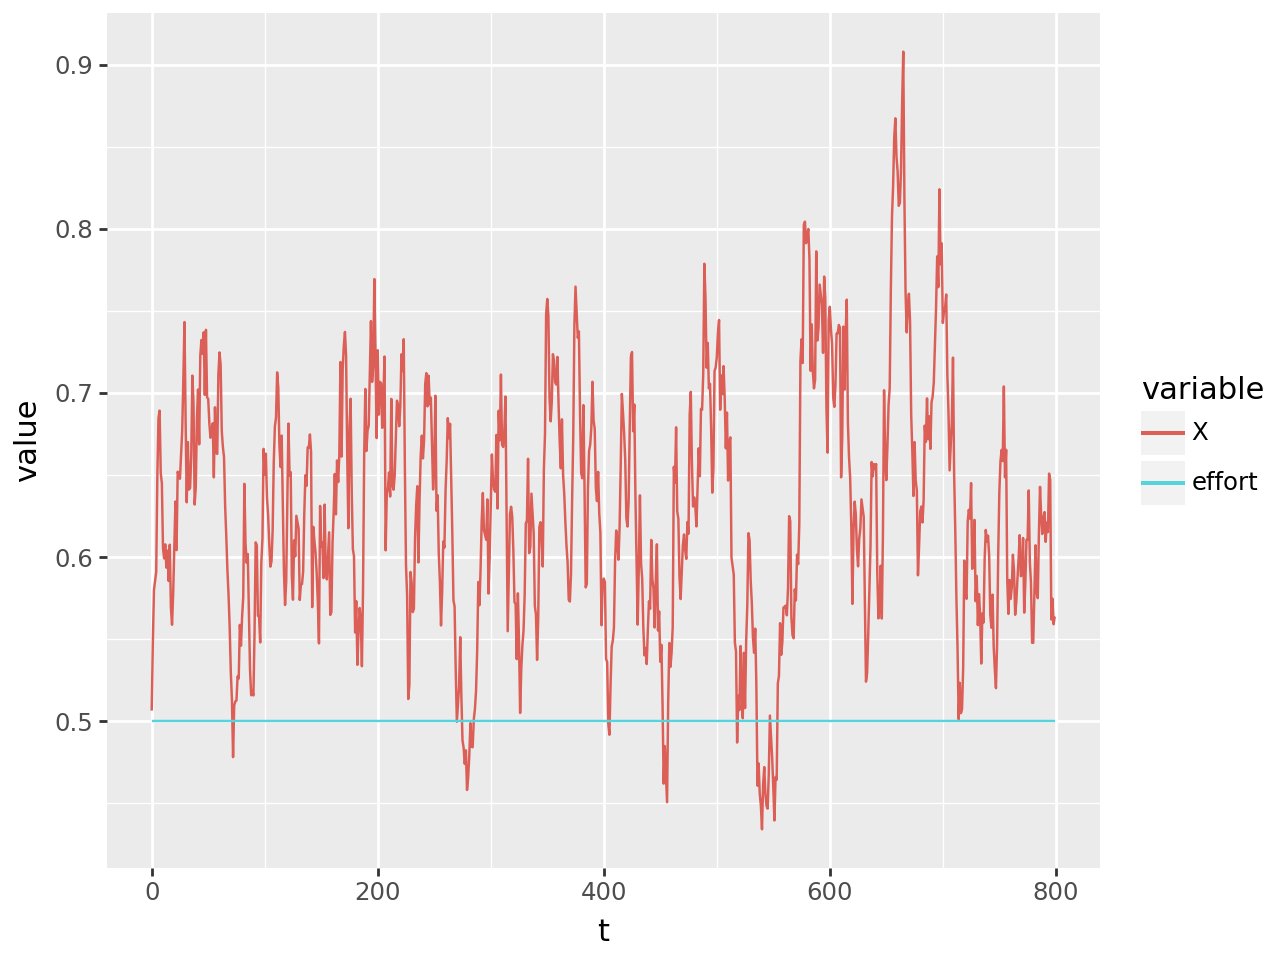

In [6]:
import numpy as np
# A simple agent
class some_agent:
    def __init__(self, effort):
        self.effort = effort

    def predict(self, obs, **kwargs):
        return self.effort

# This Agent always gives the same action:
bob = some_agent(0)

bob.predict(.5), bob.predict(.1)

(0, 0)

In [7]:
# an agent that 

class another_agent:
    def __init__(self, threshold):
        self.threshold = threshold

    def predict(self, obs, **kwargs):
        if obs < self.threshold:
            return 0
        else:
            return 1 


# This Agent is all or nothing:
tim = another_agent(0.2)

tim.predict(.4)

1

17.44955174072263


/home/rstudio/cboettig/rl-minicourse/utils.py:40: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.


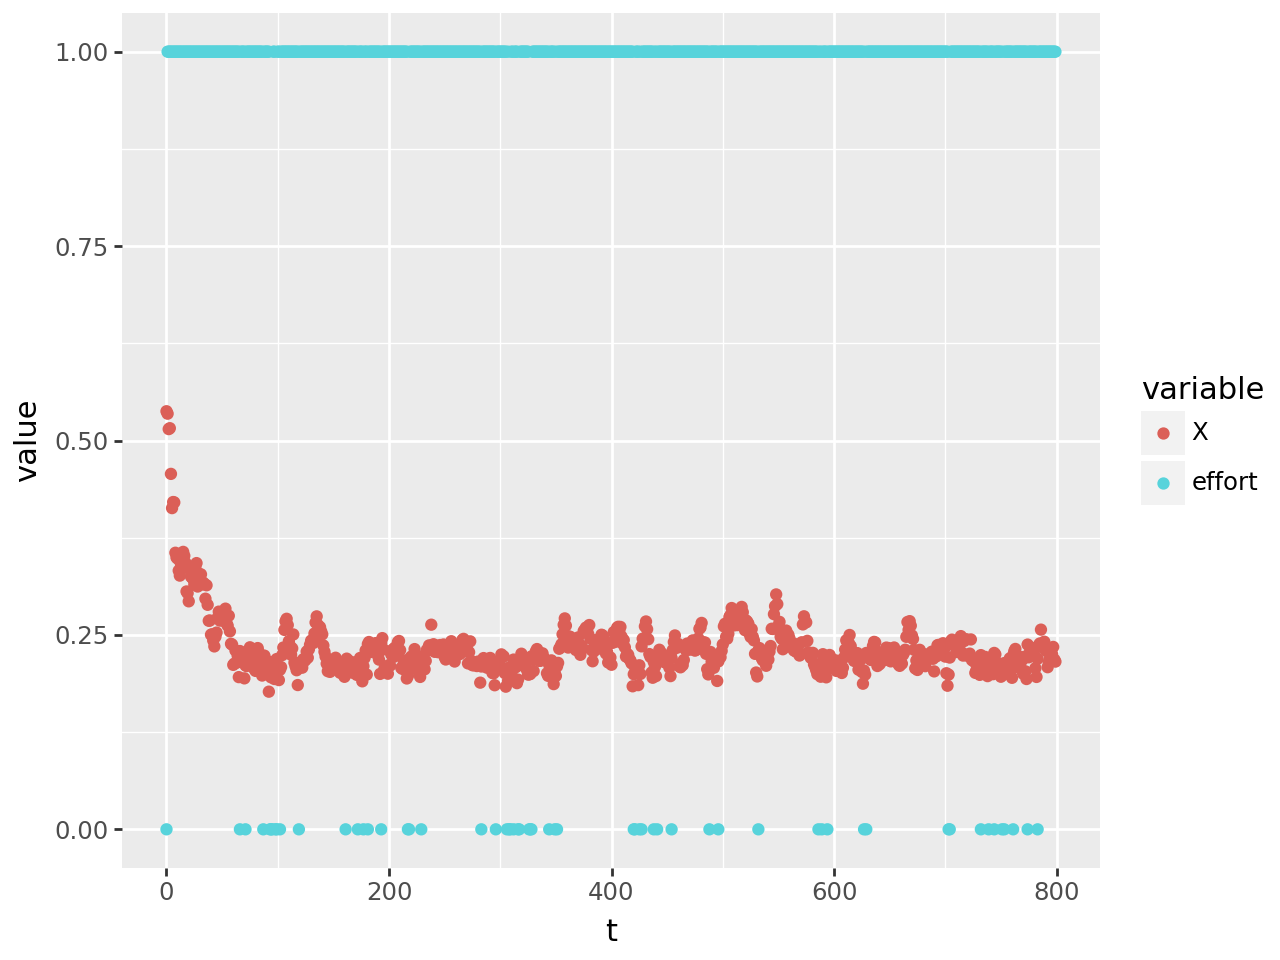

In [8]:
df = []
episode_reward = 0
obs, _ = env.reset()

for t in range(env.Tmax):
  action = tim.predict(obs)
  obs, reward, done = env.time_step(action)
  episode_reward += reward
  df.append([t, episode_reward, action, obs])
  if done:
    break

print (episode_reward)
plot_sim(df, geom = "point")